In [1]:
!nvidia-smi

Fri Aug  7 11:50:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install "torch==1.4" "torchvision==0.5.0"
!pip install torch_optimizer
!pip install ensemble-boxes
!pip install timm
!pip install -q effdet 
!pip install -q omegaconf
!pip install -q effdet omegaconf



  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-bebvqsty
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-bebvqsty
     |████████████████████████████████| 952kB 4.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65819 sha256=6456644eb6a62536d75f85c797b3d596db898556a1d5140e804a7dc957baf76d
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0508ddg/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 46.0MB/s 
  Found existing installation: to

In [3]:
import glob
import cv2
import torchvision 
import torch
import os
import copy
import random
import imgaug as ia
import numpy as np
import pandas as pd
from numba import jit
from ensemble_boxes import *
from tqdm.auto import tqdm
import albumentations as A
import torch.optim as optim
from google.colab import drive
import torch_optimizer as optim1
from torchvision import transforms
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import torch.optim.lr_scheduler as lr_scheduler 
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

%matplotlib inline
SEED = 44

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Global Wheat Detection

cuda:0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1Pwgst55XrJiQQlJ3BmIzLUd_VSPZxV38/Global Wheat Detection


In [4]:
DATA_ROOT_PATH = "/content/gdrive/My Drive/Global Wheat Detection/test"

In [5]:
import effdet
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet

In [6]:
def get_model_d7(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d7')
    model = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = DetBenchPredict(model, config)
    model.to(device)
    model.eval();
    return model

def get_model_d5(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    model = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = DetBenchPredict(model, config)
    model.to(device)
    model.eval();
    return model

In [9]:
eff_d7 = "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/אימון 1/cp33.pt"
eff_d7_26e= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/אימון 3 - לוס 0.39 - קצת אוברפיט/cp26.pt"
# resnet101_50e = "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved- RCNN-1024/אימון2 - לוס 0.68:(/cp49.pt"
# eff_d5_26= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/efficient -D7- new try/cp20.pt"
eff_d5_26= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/d5 -אימון 4/cp20.pt"

eff_D7_39e= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/אימון2/efficient-D7-39e.pt"

In [10]:
models = [
    get_model_d7(eff_d7),
    get_model_d7(eff_d7_26e),
    get_model_d7(eff_D7_39e),
    get_model_d5(eff_d5_26)
]

In [11]:
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [12]:
DATA_ROOT_PATH = "/content/gdrive/My Drive/Global Wheat Detection/test"

class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [13]:
dataset = DatasetRetriever(np.array([path.split('/')[-1][:-4] for path in glob.glob(f'{DATA_ROOT_PATH}/*.jpg')]),get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [14]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [15]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

In [16]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

In [17]:
# def make_tta_predictions(model,images, score_threshold=0.32):
#   model.eval()
#   model.to(device)
#   with torch.no_grad():
#       images = torch.stack(images).float().cuda()
#       predictions = []
#       for tta_transform in tta_transforms:
#           result = []
#           det = model(tta_transform.batch_augment(images.clone()))

#           for i in range(images.shape[0]):
#               boxes = det[i]['boxes'].detach().cpu().numpy()[:,:4]    
#               scores = det[i]['scores'].detach().cpu().numpy()[:]
#               indexes = np.where(scores > score_threshold)[0]
#               boxes = boxes[indexes]
#             #   boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
#             #   boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
#               boxes = tta_transform.deaugment_boxes(boxes.copy())
#               result.append({
#                   'boxes': boxes,
#                   'scores': scores[indexes],
#               })
#           predictions.append(result)
#   return predictions

In [18]:
def make_tta_predictions(model, images, score_threshold=0.25):
    model.eval()
    model.to(device)
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = model(tta_transform.batch_augment(images.clone()), img_size =  torch.tensor([images[0].shape[-2:]] * 1, dtype=torch.float).to(device), img_scales= torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions


In [19]:
import ensemble_boxes
from ensemble_boxes import *

# def make_ensemble_predictions(images):
#     images = list(image.to(device) for image in images)    
#     result = []
#     for model in models:
#         predictions = make_tta_predictions(model, images)
#         with torch.no_grad():
#             for i in range(len(images)):
#                 boxes, scores, labels = run_wbf(predictions, image_index=i)
#                 outputs = {'boxes': boxes,'labels': labels, 'scores':scores }
#                 result.append([outputs])
#                 torch.cuda.empty_cache()

#     return result

def make_ensemble_predictions(images):
    # images = list(image.to(device) for image in images)
    images = torch.stack(images).cuda().float()    
    result = []
    for model in models:
        with torch.no_grad():
            model.eval()
            x= torch.tensor([1]*images.shape[0]).float().cuda()
            y = torch.tensor([images[0].shape[-2:]] * 1, dtype=torch.float).to(device)
            outputs = model.forward(images, img_size=y, img_scales=x)
            results = []
            for i in range(images.shape[0]):
                boxes = outputs[i].detach().cpu().numpy()[:,:4]    
                scores = outputs[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > 0.3)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                results.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            result.append(results)
            # del model
            # gc.collect()
            torch.cuda.empty_cache()
    return result

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.3, skip_box_thr=0.3,score_threshold= 0.3, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    indexes = np.where(scores > score_threshold)[0]
    boxes = boxes[indexes]    
    scores = scores[indexes]
    boxes = boxes*(image_size)
    return boxes, scores, labels

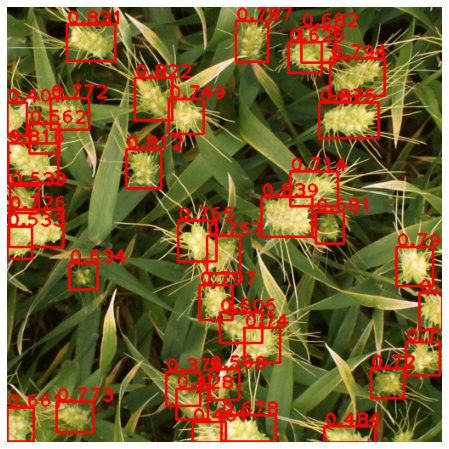

In [182]:
# for j, (images, image_ids) in enumerate(data_loader):
#     break
# predictions = make_ensemble_predictions(images)

# i = 0
# sample = images[i].permute(1,2,0).cpu().numpy()
# boxes, scores, labels = run_wbf(predictions, image_index=i)
# boxes = boxes.round().astype(np.int32).clip(min=0, max=1023)

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# for j,box in enumerate(boxes):
#     cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
#     score=str(float("{:.3f}".format(scores[j])))
    
#     cv2.putText(
#                 sample,
#                 score,
#                 org=(int(box[0]), int(box[1] )), # bottom left
#                 fontFace=cv2.FONT_HERSHEY_PLAIN,
#                 fontScale=1.5,
#                 color=(1,0, 0),
#                 thickness=2
#             )
# ax.set_axis_off()
# ax.imshow(sample);

In [20]:
validation_image_precisions = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
# model.eval()
# model.to(device)

results = []

for images, image_ids in data_loader:    
    predictions = make_ensemble_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        #plot the images
        sample = images[i].permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        for j,box in enumerate(boxes):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
            score=str(float("{:.3f}".format(scores[j])))

            cv2.putText(
              sample,
              score,
              org=(int(box[0]), int(box[1] )), # bottom left
              fontFace=cv2.FONT_HERSHEY_PLAIN,
              fontScale=1.5,
              color=(1,0, 0),
              thickness=2
            )
        ax.set_axis_off()
        ax.imshow(sample)
        


        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()